# Assignment 4
### Ethan Crow & Grayson Hineline

Note for portfolio: This project involved scraping IMDB and TheMovies.com to form a database about the top 100 movies on both websites. I did this project before I really understood how joins worked, but other than that I think the work here is solid.

In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns

## IMDB scraping
First we start off with the imbdb data.

The first webpage containing all of the data for the first 50 movies we would like to extract is given in the url below.

In [2]:
import requests
import bs4

url = "https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=1"
response = requests.get(url)


The following `soup` contains all of the html data for this given webpage we would like to be scraping

In [3]:
soup = bs4.BeautifulSoup(response.text, 'html.parser')
soup


<!DOCTYPE html>

<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>
<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
<script>(function(t){ (t.events = t.events || {})["csm_head_pre_title"] = new Date().getTime(); })(IMDbTimer);</script>
<title>Released between 2000-01-01 and 2020-12-31
(Sorted by US Box Office Descending) - IMDb</title>
<script>(function(t){ (t.events = t.events || {})["csm_head_post_title"] = new Date().getTime(); })(IMDbTimer);</script>
<script>
    if (typeof uet == 'function') {
      uet("be", "LoadTitle", {wb: 1});
    }
</script>
<script>
    if (typeof uex == 'function') {
      uex("ld", "LoadTitle", {wb: 1});
    }
</script>
<link href="https://www.imdb.com/search/title/?release_date=2000-01-01,20

Upon inspection, it seems that the class `lister-item-content` seperates all of the movies from one another. By doing `soup.find(class_="lister-item-content")`, we can therefore extract the data related to the first movie in the list.

In [4]:
movie = soup.find(class_="lister-item-content")
movie

<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt2488496/">Star Wars: Episode VII - The Force Awakens</a>
<span class="lister-item-year text-muted unbold">(2015)</span>
</h3>
<p class="text-muted">
<span class="certificate">PG-13</span>
<span class="ghost">|</span>
<span class="runtime">138 min</span>
<span class="ghost">|</span>
<span class="genre">
Action, Adventure, Sci-Fi            </span>
</p>
<div class="ratings-bar">
<div class="inline-block ratings-imdb-rating" data-value="7.8" name="ir">
<span class="global-sprite rating-star imdb-rating"></span>
<strong>7.8</strong>
</div>
<div class="inline-block ratings-user-rating">
<span class="userRatingValue" data-tconst="tt2488496" id="urv_tt2488496">
<span class="global-sprite rating-star no-rating"></span>
<span class="rate" data-no-rating="Rate this" data-value="0" name="ur">Rate this</span>
</span>
<div class="starBarWidget" id="sb_tt2

We found that the first `<a` in `movie` gives the title,

In [5]:
movie.a.text #title

'Star Wars: Episode VII - The Force Awakens'

the class `runtime` gives the runtime of the movie,

In [6]:
movie.find(class_="runtime").text #runtime

'138 min'

the name `strong` gives the user rating of the movie,

In [7]:
movie.find('strong').text #user rating

'7.8'

the class `metascore favorable` gives the metascore of the movie, (however, this might not be useful for movies that don't have a 'favorable' metascore)

In [8]:
movie.find(class_="metascore favorable").text #metascore - maybe only for good ratings

'80        '

to find the rating count, we did the following,

In [9]:
movie.find(itemprop = "ratingCount")

<meta content="887830" itemprop="ratingCount"/>

In [10]:
movie.find(itemprop = "ratingCount").text

''

In [11]:
movie.find(itemprop="ratingCount")["content"] #rating count

'887830'

and finally to get the IMDB gross, we found all of the `<span` values, then grabbed the last one in the list, then got the data-value from it.

In [12]:
movie.find_all('span')

[<span class="lister-item-index unbold text-primary">1.</span>,
 <span class="lister-item-year text-muted unbold">(2015)</span>,
 <span class="certificate">PG-13</span>,
 <span class="ghost">|</span>,
 <span class="runtime">138 min</span>,
 <span class="ghost">|</span>,
 <span class="genre">
 Action, Adventure, Sci-Fi            </span>,
 <span class="global-sprite rating-star imdb-rating"></span>,
 <span class="userRatingValue" data-tconst="tt2488496" id="urv_tt2488496">
 <span class="global-sprite rating-star no-rating"></span>
 <span class="rate" data-no-rating="Rate this" data-value="0" name="ur">Rate this</span>
 </span>,
 <span class="global-sprite rating-star no-rating"></span>,
 <span class="rate" data-no-rating="Rate this" data-value="0" name="ur">Rate this</span>,
 <span class="rating-bg"> </span>,
 <span class="rating-imdb" style="width: 109.2px"> </span>,
 <span class="rating-stars">
 <a href="/register/login?why=vote" rel="nofollow" title="Register or login to rate this ti

In [13]:
movie.find_all('span')[-1]

<span data-value="936,662,225" name="nv">$936.66M</span>

In [14]:
movie.find_all('span')[-1]["data-value"] #gross

'936,662,225'

After figuring out how to get the IMDB gross, we also figured out that the metascore is included in that list of `span` values. By simply extracting it from the list, we could ignore the 'metascore favorable' problem.

In [15]:
movie.find_all('span')[-7].text #metascore

'80        '

Now we need to try and do all of what we just did to every movie on the webpage. We know that every movie is seperated by the class `lister-item-content`, so therefore we can just make a list of all the movies by making a list of all of those.

In [16]:
movies = soup.find_all(class_="lister-item-content")
movies[2] #this pulls out the 3rd movie listed on the webpage

<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">3.</span>
<a href="/title/tt0499549/">Avatar</a>
<span class="lister-item-year text-muted unbold">(2009)</span>
</h3>
<p class="text-muted">
<span class="certificate">PG-13</span>
<span class="ghost">|</span>
<span class="runtime">162 min</span>
<span class="ghost">|</span>
<span class="genre">
Action, Adventure, Fantasy            </span>
</p>
<div class="ratings-bar">
<div class="inline-block ratings-imdb-rating" data-value="7.8" name="ir">
<span class="global-sprite rating-star imdb-rating"></span>
<strong>7.8</strong>
</div>
<div class="inline-block ratings-user-rating">
<span class="userRatingValue" data-tconst="tt0499549" id="urv_tt0499549">
<span class="global-sprite rating-star no-rating"></span>
<span class="rate" data-no-rating="Rate this" data-value="0" name="ur">Rate this</span>
</span>
<div class="starBarWidget" id="sb_tt0499549">
<div class="rating rating-

Now that we know how to extract all the data we want from any given movie on this page, we just need to put all of the data into a df.

In [17]:
#creating columns for the df
col = ["Title", "Runtime", "User Rating", "Metascore", "Votes", "Imdb Gross", "Genre"]

In [18]:
#making the dataframe
moviedf = pd.DataFrame(columns = col)

The following is a loop that takes all of the data from each individual movie in the webpage, then procedually adds each movie's data to the correct list for that data. Once all of the data for the webpage have been extracted, we just put all of the data from the lists into our df's columns.

In [19]:
titles = []
runtimes = []
user_ratings = []
metascores = []
votes = []
gross = []
genres = []
for movie in movies:
    titles.append(movie.a.text)
    runtimes.append(movie.find(class_="runtime").text)
    user_ratings.append(movie.find('strong').text)
    metascores.append(movie.find_all('span')[-7].text)
    votes.append(movie.find(itemprop="ratingCount")["content"])
    gross.append(movie.find_all('span')[-1]["data-value"])
    genres.append(movie.find(class_="genre").text.split(',')[0].lstrip('\n'))
    
moviedf["Title"] = pd.Series(titles)
moviedf["Runtime"] = pd.Series(runtimes)
moviedf["User Rating"] = pd.Series(user_ratings)
moviedf["Metascore"] = pd.Series(metascores)
moviedf["Votes"] = pd.Series(votes)
moviedf["Imdb Gross"] = pd.Series(gross)
moviedf["Genre"] = pd.Series(genres)
moviedf

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138 min,7.8,80,887830,"936,662,225",Action
1,Avengers: Endgame,181 min,8.4,78,951959,"858,373,000",Action
2,Avatar,162 min,7.8,83,1160469,"760,507,625",Action
3,Black Panther,134 min,7.3,88,681794,"700,059,566",Action
4,Avengers: Infinity War,149 min,8.4,68,933757,"678,815,482",Action
5,Jurassic World,124 min,7.0,59,603438,"652,270,625",Action
6,The Avengers,143 min,8.0,69,1313011,"623,279,547",Action
7,Star Wars: Episode VIII - The Last Jedi,152 min,6.9,84,591528,"620,181,382",Action
8,Incredibles 2,118 min,7.6,80,270721,"608,581,744",Animation
9,The Lion King,118 min,6.8,55,227720,"543,638,043",Animation


Looks like it worked! Now we just have to apply it to all 1000 movies.

To do so, we'll make a list of all of the urls we want to extract. Rather than writing out the urls of all 20 webpages, we can just do the following for loop to generate the urls through simple string contatentation.

In [20]:
base_url = "https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start="
urls = []
for i in range(20):
    url = base_url + str(i*50 + 1)
    urls.append(url)

In [21]:
urls

['https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=1',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=51',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=101',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=151',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=201',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=251',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=301',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,desc&start=351',
 'https://www.imdb.com/search/title/?release_date=2000-01-01,2020-12-31&sort=boxoffice_gross_us,des

Now we'll do the same data extraction process as before, but on all of the urls such that we can get the data on all 1000 movies.

In [22]:
moviedf = pd.DataFrame(columns = col)
titles = []
runtimes = []
user_ratings = []
metascores = []
votes = []
gross = []
genres = []
for url in urls:
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    movies = soup.find_all(class_="lister-item-content")
    for movie in movies:
        titles.append(movie.a.text)
        runtimes.append(movie.find(class_="runtime").text)
        user_ratings.append(movie.find('strong').text)
        metascores.append(movie.find_all('span')[-7].text)
        votes.append(movie.find(itemprop="ratingCount")["content"])
        gross.append(movie.find_all('span')[-1]["data-value"])
        genres.append(movie.find(class_="genre").text.split(',')[0].lstrip('\n'))
    time.sleep(1)

moviedf["Title"] = pd.Series(titles)
moviedf["Runtime"] = pd.Series(runtimes)
moviedf["User Rating"] = pd.Series(user_ratings)
moviedf["Metascore"] = pd.Series(metascores)
moviedf["Votes"] = pd.Series(votes)
moviedf["Imdb Gross"] = pd.Series(gross)
moviedf["Genre"] = pd.Series(genres)
    
moviedf

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138 min,7.8,80,887830,"936,662,225",Action
1,Avengers: Endgame,181 min,8.4,78,951959,"858,373,000",Action
2,Avatar,162 min,7.8,83,1160469,"760,507,625",Action
3,Black Panther,134 min,7.3,88,681794,"700,059,566",Action
4,Avengers: Infinity War,149 min,8.4,68,933757,"678,815,482",Action
...,...,...,...,...,...,...,...
995,Son of God,138 min,5.7,37,18733,"59,700,064",Biography
996,Love Actually,135 min,7.6,55,449026,"59,696,144",Comedy
997,Gothika,98 min,5.8,38,110559,"59,694,580",Horror
998,My Big Fat Greek Wedding 2,94 min,6.0,37,29646,"59,689,605",Comedy


And then we turn it into a csv for later.

In [23]:
moviedf.to_csv("imdb_movies.csv", index=False) #downloaded csv

## The Numbers scraping
Next we're going to scrape the numbers...

Same initial process as before...

In [24]:
url = "https://www.the-numbers.com/movie/budgets/all"
response = requests.get(url)
soup = bs4.BeautifulSoup(response.text, 'html.parser')
soup

<!DOCTYPE html>

<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<!-- Global site tag (gtag.js) - Google Analytics -->
<script async="" src="https://www.googletagmanager.com/gtag/js?id=UA-1343128-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-1343128-1');
</script>
<meta content='(PICS-1.1 "https://www.icra.org/ratingsv02.html" l gen true for "https://www.the-numbers.com/" r (cb 1 lz 1 nz 1 oz 1 vz 1) "https://www.rsac.org/ratingsv01.html" l gen true for "https://www.the-numbers.com/" r (n 0 s 0 v 0 l 0))' http-equiv="PICS-Label"/>
<!--<meta http-equiv="Content-Type" content="text/html; charset=ISO-8859-1" >-->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="telephone=no" name="format-detection"/> <!-- for apple mobile -->
<meta content="521546213" property="fb:admins">
<meta content="initial-scale=

We found that all the movies are seperated by the tag `<tr><td class="data">`, and we can extract the data for each movie by just pulling out an index from a list of all `tr` tags. However, we noticed that the first `tr` is a header for the table in the url, so we just need to skip that one.

In [25]:
soup.find_all('tr')

[<tr><th> </th><th>Release<br/>Date</th><th>Movie</th><th>Production<br/>Budget</th><th>Domestic<br/>Gross</th><th>Worldwide<br/>Gross</th></tr>,
 <tr><td class="data">1</td>
 <td><a href="/box-office-chart/daily/2019/04/23">Apr 23, 2019</a></td>
 <td><b><a href="/movie/Avengers-Endgame-(2019)#tab=summary">Avengers: Endgame</a></b></td>
 <td class="data"> $400,000,000</td>
 <td class="data"> $858,373,000</td>
 <td class="data"> $2,797,800,564</td>
 </tr>,
 <tr><td class="data">2</td>
 <td><a href="/box-office-chart/daily/2011/05/20">May 20, 2011</a></td>
 <td><b><a href="/movie/Pirates-of-the-Caribbean-On-Stranger-Tides#tab=summary">Pirates of the Caribbean: On Stranger Tides</a></b></td>
 <td class="data"> $379,000,000</td>
 <td class="data"> $241,071,802</td>
 <td class="data"> $1,045,713,802</td>
 </tr>,
 <tr><td class="data">3</td>
 <td><a href="/box-office-chart/daily/2015/04/22">Apr 22, 2015</a></td>
 <td><b><a href="/movie/Avengers-Age-of-Ultron#tab=summary">Avengers: Age of Ult

In [26]:
movie = soup.find_all('tr')[1] #index of 1 because we are skipping the table headings.
movie

<tr><td class="data">1</td>
<td><a href="/box-office-chart/daily/2019/04/23">Apr 23, 2019</a></td>
<td><b><a href="/movie/Avengers-Endgame-(2019)#tab=summary">Avengers: Endgame</a></b></td>
<td class="data"> $400,000,000</td>
<td class="data"> $858,373,000</td>
<td class="data"> $2,797,800,564</td>
</tr>

After playing around with this the above extraction, we figured out how to pull out the desired data by doing the following...

In [27]:
movie.find_all('a')

[<a href="/box-office-chart/daily/2019/04/23">Apr 23, 2019</a>,
 <a href="/movie/Avengers-Endgame-(2019)#tab=summary">Avengers: Endgame</a>]

In [28]:
movie.find_all('a')[0].text #release date

'Apr 23, 2019'

In [29]:
movie.find_all('a')[1].text #title

'Avengers: Endgame'

In [30]:
movie.find_all(class_ = "data")

[<td class="data">1</td>,
 <td class="data"> $400,000,000</td>,
 <td class="data"> $858,373,000</td>,
 <td class="data"> $2,797,800,564</td>]

In [31]:
movie.find_all(class_ = "data")[1].text

'\xa0$400,000,000'

In [32]:
movie.find_all(class_ = "data")[1].text.lstrip('\xa0$') #production budget

'400,000,000'

In [33]:
movie.find_all(class_ = "data")[2].text.lstrip('\xa0$') #domestic gross

'858,373,000'

In [34]:
movie.find_all(class_ = "data")[3].text.lstrip('\xa0$') #worldwide gross

'2,797,800,564'

Once we figured out how to extract the data for the first movie, we wanted to make sure we could do the same method to each movie in the list of `tr` tages.

In [35]:
movie = soup.find_all('tr')[100]
movie

<tr><td class="data">100</td>
<td><a href="/box-office-chart/daily/2016/11/14">Nov 14, 2016</a></td>
<td><b><a href="/movie/Fantastic-Beasts-and-Where-to-Find-Them#tab=summary">Fantastic Beasts and Where to Find Them</a></b></td>
<td class="data"> $180,000,000</td>
<td class="data"> $234,037,575</td>
<td class="data"> $811,724,385</td>
</tr>

In [36]:
movie.find_all('a')[0].text #release date

'Nov 14, 2016'

In [37]:
movie.find_all('a')[1].text #title

'Fantastic Beasts and Where to Find Them'

In [38]:
movie.find_all(class_ = "data")[1].text.lstrip('\xa0$') #production budget

'180,000,000'

In [39]:
movie.find_all(class_ = "data")[2].text.lstrip('\xa0$') #domestic gross

'234,037,575'

In [40]:
movie.find_all(class_ = "data")[3].text.lstrip('\xa0$') #worldwide gross

'811,724,385'

Seemed like it worked, so now we just need to apply the same methodology we used for the IMDB data extraction process to get the data for all 1000 movies.

In [41]:
#making a list of the urls like before
base_url = "https://www.the-numbers.com/movie/budgets/all"
urls = []
urls.append(base_url)
for i in range(1,10):
    url = base_url + "/" + str(i*100 + 1)
    urls.append(url)
urls

['https://www.the-numbers.com/movie/budgets/all',
 'https://www.the-numbers.com/movie/budgets/all/101',
 'https://www.the-numbers.com/movie/budgets/all/201',
 'https://www.the-numbers.com/movie/budgets/all/301',
 'https://www.the-numbers.com/movie/budgets/all/401',
 'https://www.the-numbers.com/movie/budgets/all/501',
 'https://www.the-numbers.com/movie/budgets/all/601',
 'https://www.the-numbers.com/movie/budgets/all/701',
 'https://www.the-numbers.com/movie/budgets/all/801',
 'https://www.the-numbers.com/movie/budgets/all/901']

In [42]:
#building the new dataframe to store the data in
cols = ["Release Date", "Title", "Budget", "Domestic Gross", "Worldwide Gross"]
moviedf = pd.DataFrame(columns = cols)
#creating lists to store the scraped data in
releaseDates = []
titles = []
budgets = []
d_gross = []
w_gross = []
#looping through all of the urls to get all the needed data
for url in urls:
    response = requests.get(url)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    movies = soup.find_all('tr')
    for movie in movies[1:]:
        releaseDates.append(movie.find_all('a')[0].text)
        titles.append(movie.find_all('a')[1].text)
        budgets.append(movie.find_all(class_ = "data")[1].text.lstrip('\xa0$'))
        d_gross.append(movie.find_all(class_ = "data")[2].text.lstrip('\xa0$'))
        w_gross.append(movie.find_all(class_ = "data")[3].text.lstrip('\xa0$'))
    time.sleep(1)

#putting together the dataframe
moviedf["Release Date"] = pd.Series(releaseDates)
moviedf["Title"] = pd.Series(titles)
moviedf["Budget"] = pd.Series(budgets)
moviedf["Domestic Gross"] = pd.Series(d_gross)
moviedf["Worldwide Gross"] = pd.Series(w_gross)
    
moviedf

,Release Date,Title,Budget,Domestic Gross,Worldwide Gross
0,"Apr 23, 2019",Avengers: Endgame,"400,000,000","858,373,000","2,797,800,564"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"379,000,000","241,071,802","1,045,713,802"
2,"Apr 22, 2015",Avengers: Age of Ultron,"365,000,000","459,005,868","1,395,316,979"
3,"Dec 16, 2015",Star Wars Ep. VII: The Force Awakens,"306,000,000","936,662,225","2,064,615,817"
4,"Apr 25, 2018",Avengers: Infinity War,"300,000,000","678,815,482","2,044,540,523"
...,...,...,...,...,...
995,"Dec 25, 2008",The Spirit,"60,000,000","19,806,188","39,006,188"
996,"Oct 19, 2001",The Last Castle,"60,000,000","18,208,078","20,541,668"
997,"Jan 23, 2009",Inkheart,"60,000,000","17,303,424","66,655,938"
998,"Feb 18, 2020",Monster Hunter,"60,000,000","15,104,790","44,400,541"


In [43]:
moviedf.to_csv("numbers_movies.csv", index=False)

## Data cleaning

We opted to clean the dataframes before we merged them, just because both dataframes probably have issues with their string data that require different solutions, and doing them seperately avoids us the promblem of having to clean two things at once.

In [44]:
import pandas as pd
import numpy as np
import time

In [45]:
imdb = pd.read_csv("imdb_movies.csv")
numbers = pd.read_csv("numbers_movies.csv")

First we'll clean IMDB.

In [46]:
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138 min,7.8,80,887830,"936,662,225",Action
1,Avengers: Endgame,181 min,8.4,78,951959,"858,373,000",Action
2,Avatar,162 min,7.8,83,1160469,"760,507,625",Action
3,Black Panther,134 min,7.3,88,681794,"700,059,566",Action
4,Avengers: Infinity War,149 min,8.4,68,933757,"678,815,482",Action
...,...,...,...,...,...,...,...
995,Son of God,138 min,5.7,37,18733,"59,700,064",Biography
996,Love Actually,135 min,7.6,55,449026,"59,696,144",Comedy
997,Gothika,98 min,5.8,38,110559,"59,694,580",Horror
998,My Big Fat Greek Wedding 2,94 min,6.0,37,29646,"59,689,605",Comedy


The 'Runtime' column is in string format and has 'min' tacked on to the end of each string. Lets strip the ' min' from the strings and convert the numbers to integers.

In [47]:
temp_col = imdb["Runtime"].str.rstrip(" min")
imdb["Runtime"] = temp_col.astype(int)
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138,7.8,80,887830,"936,662,225",Action
1,Avengers: Endgame,181,8.4,78,951959,"858,373,000",Action
2,Avatar,162,7.8,83,1160469,"760,507,625",Action
3,Black Panther,134,7.3,88,681794,"700,059,566",Action
4,Avengers: Infinity War,149,8.4,68,933757,"678,815,482",Action
...,...,...,...,...,...,...,...
995,Son of God,138,5.7,37,18733,"59,700,064",Biography
996,Love Actually,135,7.6,55,449026,"59,696,144",Comedy
997,Gothika,98,5.8,38,110559,"59,694,580",Horror
998,My Big Fat Greek Wedding 2,94,6.0,37,29646,"59,689,605",Comedy


User rating is more simple. All we have to do is convert the strings to floats.

In [48]:
temp_col = imdb["User Rating"]
imdb["User Rating"] = temp_col.astype(float)
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138,7.8,80,887830,"936,662,225",Action
1,Avengers: Endgame,181,8.4,78,951959,"858,373,000",Action
2,Avatar,162,7.8,83,1160469,"760,507,625",Action
3,Black Panther,134,7.3,88,681794,"700,059,566",Action
4,Avengers: Infinity War,149,8.4,68,933757,"678,815,482",Action
...,...,...,...,...,...,...,...
995,Son of God,138,5.7,37,18733,"59,700,064",Biography
996,Love Actually,135,7.6,55,449026,"59,696,144",Comedy
997,Gothika,98,5.8,38,110559,"59,694,580",Horror
998,My Big Fat Greek Wedding 2,94,6.0,37,29646,"59,689,605",Comedy


Now we want to clean the "Metascore" values. After trying to convert the values to integers, we found that it just would not work. So we opted to look at the values within the column.

In [49]:
imdb["Metascore"].value_counts().sort_index()

12            1
13            1
16            2
19            2
20            1
             ..
92            2
94            6
95            3
96            2
X             4
Name: Metascore, Length: 80, dtype: int64

In [50]:
imdb[imdb["Metascore"] == "X"]

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
424,Janatha Garage,162,7.3,X,6543,"120,500,000",Action
666,Dolphins,39,7.2,X,497,"84,400,000",Documentary
848,Good Boys,90,6.7,X,69242,"69,056,735",Adventure
857,National Theatre Live: The Curious Incident of...,160,8.5,X,331,"68,321,433",Drama


It seems that some movies just didn't get metascore values. After looking at IMDB and looking at these 4 movies individually, it is the case that these movies just didn't recieve metascores. So in the absense of data for them, we will just convert these values to NaNs.

In [51]:
indexes = [424, 666, 848, 857]
for index in indexes:
    imdb.iloc[index, 3] = np.nan

In [52]:
imdb.iloc[indexes]

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
424,Janatha Garage,162,7.3,NaN,6543,"120,500,000",Action
666,Dolphins,39,7.2,NaN,497,"84,400,000",Documentary
848,Good Boys,90,6.7,NaN,69242,"69,056,735",Adventure
857,National Theatre Live: The Curious Incident of...,160,8.5,NaN,331,"68,321,433",Drama


Now that they are NaN's, we can convert the columns data to numerical data. Sadly, if we want to keep the rows without Metascores and we want to put the Metascore for those movies as NaN's, we have to convert all of the movies' metascores to floats (even though ideally they would be integers).

In [53]:
temp_col = imdb["Metascore"].str.rstrip()
imdb["Metascore"] = temp_col.astype(float)
imdb.sort_values(by = "Metascore")

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
647,The Emoji Movie,86,3.3,12.0,60508,"86,089,513",Animation
824,Paul Blart: Mall Cop 2,94,4.4,13.0,36096,"71,038,190",Action
972,God's Not Dead,113,4.7,16.0,41926,"60,755,732",Drama
878,Kangaroo Jack,89,4.4,16.0,30866,"66,934,963",Action
542,The Cat in the Hat,82,4.0,19.0,80025,"101,149,285",Adventure
...,...,...,...,...,...,...,...
173,Ratatouille,111,8.0,96.0,672669,"206,445,654",Animation
424,Janatha Garage,162,7.3,NaN,6543,"120,500,000",Action
666,Dolphins,39,7.2,NaN,497,"84,400,000",Documentary
848,Good Boys,90,6.7,NaN,69242,"69,056,735",Adventure


Moving on, we converted "Votes" to integers,

In [54]:
temp_col = imdb["Votes"].astype(int)
imdb["Votes"] = temp_col
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138,7.8,80.0,887830,"936,662,225",Action
1,Avengers: Endgame,181,8.4,78.0,951959,"858,373,000",Action
2,Avatar,162,7.8,83.0,1160469,"760,507,625",Action
3,Black Panther,134,7.3,88.0,681794,"700,059,566",Action
4,Avengers: Infinity War,149,8.4,68.0,933757,"678,815,482",Action
...,...,...,...,...,...,...,...
995,Son of God,138,5.7,37.0,18733,"59,700,064",Biography
996,Love Actually,135,7.6,55.0,449026,"59,696,144",Comedy
997,Gothika,98,5.8,38.0,110559,"59,694,580",Horror
998,My Big Fat Greek Wedding 2,94,6.0,37.0,29646,"59,689,605",Comedy


and removed the columns fromt the Imdb gross column to change the values to integers.

In [55]:
temp_col = imdb["Imdb Gross"].str.replace(',','').astype(int)
imdb["Imdb Gross"] = temp_col
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138,7.8,80.0,887830,936662225,Action
1,Avengers: Endgame,181,8.4,78.0,951959,858373000,Action
2,Avatar,162,7.8,83.0,1160469,760507625,Action
3,Black Panther,134,7.3,88.0,681794,700059566,Action
4,Avengers: Infinity War,149,8.4,68.0,933757,678815482,Action
...,...,...,...,...,...,...,...
995,Son of God,138,5.7,37.0,18733,59700064,Biography
996,Love Actually,135,7.6,55.0,449026,59696144,Comedy
997,Gothika,98,5.8,38.0,110559,59694580,Horror
998,My Big Fat Greek Wedding 2,94,6.0,37.0,29646,59689605,Comedy


Finally, we removed any extra spaces from the ends of the genres' of the movies.

In [56]:
temp_col = imdb["Genre"].str.strip()
imdb["Genre"] = temp_col
imdb

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre
0,Star Wars: Episode VII - The Force Awakens,138,7.8,80.0,887830,936662225,Action
1,Avengers: Endgame,181,8.4,78.0,951959,858373000,Action
2,Avatar,162,7.8,83.0,1160469,760507625,Action
3,Black Panther,134,7.3,88.0,681794,700059566,Action
4,Avengers: Infinity War,149,8.4,68.0,933757,678815482,Action
...,...,...,...,...,...,...,...
995,Son of God,138,5.7,37.0,18733,59700064,Biography
996,Love Actually,135,7.6,55.0,449026,59696144,Comedy
997,Gothika,98,5.8,38.0,110559,59694580,Horror
998,My Big Fat Greek Wedding 2,94,6.0,37.0,29646,59689605,Comedy


One last thing before we're done with this data. Since we know the movies are ordered by index by Box office, we can create a column of the movies box office ranking on IMDB to later be able to compare with how The N

In [57]:
imdb.describe()

,Runtime,User Rating,Metascore,Votes,Imdb Gross
count,1000.000000,1000.00000,996.000000,1.000000e+03,1.000000e+03
mean,113.946000,6.62280,56.997992,2.821214e+05,1.428483e+08
std,20.015537,0.91934,16.055870,2.666909e+05,1.026680e+08
min,39.000000,1.60000,12.000000,3.310000e+02,5.965022e+07
25%,99.000000,6.10000,45.000000,1.071358e+05,7.660087e+07
50%,111.000000,6.60000,57.000000,2.047575e+05,1.075142e+08
75%,126.000000,7.30000,69.000000,3.802542e+05,1.692319e+08
max,201.000000,9.00000,96.000000,2.432726e+06,9.366622e+08


In [58]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        1000 non-null   object 
 1   Runtime      1000 non-null   int64  
 2   User Rating  1000 non-null   float64
 3   Metascore    996 non-null    float64
 4   Votes        1000 non-null   int64  
 5   Imdb Gross   1000 non-null   int64  
 6   Genre        1000 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


The numbers data is much simpler to clean. For budget, domestic gross, and worldwide gross, the only thing that needs to be done is the removal of the commas.

In [59]:
temp_col = numbers["Budget"].str.replace(',', '')
numbers["Budget"] = temp_col.astype(int)

In [60]:
temp_col = numbers["Domestic Gross"].str.replace(',', '')
numbers["Domestic Gross"] = temp_col.astype(int)

In [61]:
temp_col = numbers["Worldwide Gross"].str.replace(',', '')
numbers["Worldwide Gross"] = temp_col.astype(int)

## Merging and analyzing the combined DataFrame

The following merges the two dataframes together.

In [62]:
merged = imdb.merge(numbers, how = "outer", on = "Title")
merged.sort_index()

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre,Release Date,Budget,Domestic Gross,Worldwide Gross
0,Star Wars: Episode VII - The Force Awakens,138.0,7.8,80.0,887830.0,936662225.0,Action,NaN,NaN,NaN,NaN
1,Avengers: Endgame,181.0,8.4,78.0,951959.0,858373000.0,Action,"Apr 23, 2019",400000000.0,858373000.0,2.797801e+09
2,Avatar,162.0,7.8,83.0,1160469.0,760507625.0,Action,"Dec 17, 2009",237000000.0,760507625.0,2.845900e+09
3,Black Panther,134.0,7.3,88.0,681794.0,700059566.0,Action,"Feb 13, 2018",200000000.0,700059566.0,1.336494e+09
4,Avengers: Infinity War,149.0,8.4,68.0,933757.0,678815482.0,Action,"Apr 25, 2018",300000000.0,678815482.0,2.044541e+09
...,...,...,...,...,...,...,...,...,...,...,...
1486,The Spirit,NaN,NaN,NaN,NaN,NaN,NaN,"Dec 25, 2008",60000000.0,19806188.0,3.900619e+07
1487,The Last Castle,NaN,NaN,NaN,NaN,NaN,NaN,"Oct 19, 2001",60000000.0,18208078.0,2.054167e+07
1488,Inkheart,NaN,NaN,NaN,NaN,NaN,NaN,"Jan 23, 2009",60000000.0,17303424.0,6.665594e+07
1489,Monster Hunter,NaN,NaN,NaN,NaN,NaN,NaN,"Feb 18, 2020",60000000.0,15104790.0,4.440054e+07


Notice how there are now 1490 rows. Duplicate movies exist (i.e., Star Wars 7 exists twice) but to eliminate the duplicates is extremely difficult based on string matching (through libraries such as `thefuzz`) given that movies such as "Frozen" and "Frozen II" exist in both dataframes.

Now lets look at the descriptive stats of the df:

In [63]:
merged.describe()

,Runtime,User Rating,Metascore,Votes,Imdb Gross,Budget,Domestic Gross,Worldwide Gross
count,1006.000000,1006.000000,1002.000000,1.006000e+03,1.006000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,113.994036,6.622266,56.976048,2.829561e+05,1.436123e+08,1.086401e+08,1.249678e+08,3.233100e+08
std,20.002735,0.918685,16.033164,2.679565e+05,1.043084e+08,5.036677e+07,1.151387e+08,3.204934e+08
min,39.000000,1.600000,12.000000,3.310000e+02,5.965022e+07,6.000000e+07,0.000000e+00,0.000000e+00
25%,99.000000,6.100000,45.000000,1.075555e+05,7.667609e+07,7.000000e+07,4.782597e+07,1.132509e+08
50%,111.000000,6.600000,57.000000,2.052445e+05,1.075142e+08,9.000000e+07,9.250479e+07,2.210127e+08
75%,126.000000,7.300000,68.750000,3.806908e+05,1.696769e+08,1.364000e+08,1.630492e+08,4.162202e+08
max,201.000000,9.000000,96.000000,2.432726e+06,9.366622e+08,4.000000e+08,9.366622e+08,2.845900e+09


Not very instructive given that all the columns are floats.

In [64]:
merged.info() #floats now?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 1490
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1491 non-null   object 
 1   Runtime          1006 non-null   float64
 2   User Rating      1006 non-null   float64
 3   Metascore        1002 non-null   float64
 4   Votes            1006 non-null   float64
 5   Imdb Gross       1006 non-null   float64
 6   Genre            1006 non-null   object 
 7   Release Date     1000 non-null   object 
 8   Budget           1000 non-null   float64
 9   Domestic Gross   1000 non-null   float64
 10  Worldwide Gross  1000 non-null   float64
dtypes: float64(8), object(3)
memory usage: 139.8+ KB


For some reason, all of the integer columns in both dataframes were converted to floats during the merging process. Fortunately, this won't affect analysis.

------------------------------

First, we decided to examine how the budgets of movies relate to the values in the other columns.

In [65]:
cols = ['Runtime',
 'User Rating',
 'Metascore',
 'Votes',
 'Imdb Gross','Domestic Gross',
 'Worldwide Gross']
cols

['Runtime',
 'User Rating',
 'Metascore',
 'Votes',
 'Imdb Gross',
 'Domestic Gross',
 'Worldwide Gross']

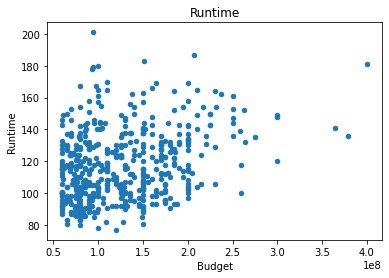

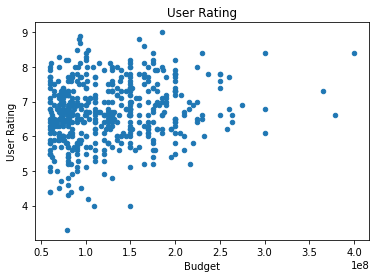

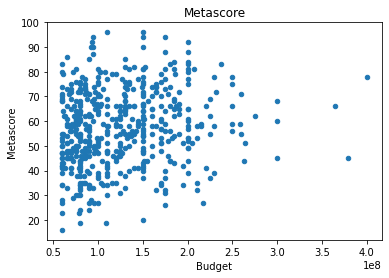

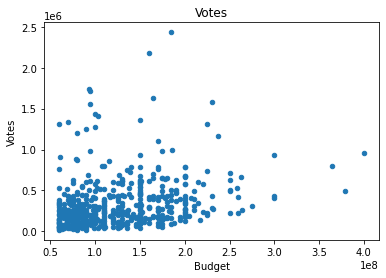

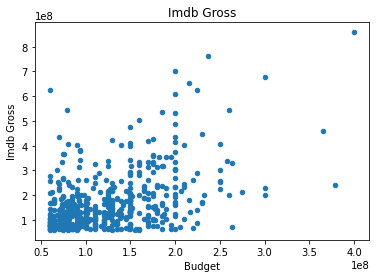

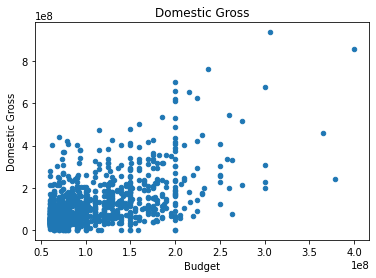

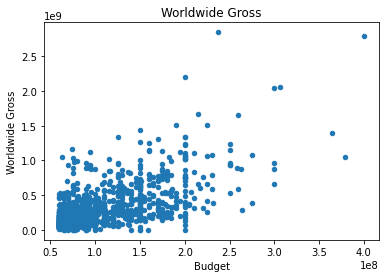

In [66]:
for col in cols:
    merged.plot.scatter(x = "Budget", y = col, title = col)

Each graph tends to follow a slight upwards trend, with lots of variation. Generally, movies with very high budgets do not perform poorly across the various metrics. However, this does not exclude the possibility of outliers. 

Notice on the graph of Budget vs Imdb Gross, one movie had a massive budget, but a very low value for IMDB gross. Let's try and find that movie.

In [67]:
merged[merged["Budget"] > 3.5*10**8]

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre,Release Date,Budget,Domestic Gross,Worldwide Gross
1,Avengers: Endgame,181.0,8.4,78.0,951959.0,858373000.0,Action,"Apr 23, 2019",400000000.0,858373000.0,2.797801e+09
18,Avengers: Age of Ultron,141.0,7.3,66.0,795756.0,459005868.0,Action,"Apr 22, 2015",365000000.0,459005868.0,1.395317e+09
124,Pirates of the Caribbean: On Stranger Tides,136.0,6.6,45.0,499436.0,241063875.0,Action,"May 20, 2011",379000000.0,241071802.0,1.045714e+09


"Pirates of the Caribbean: On Stranger Tides" was the movie. How much money did it lose worldwide?

In [68]:
merged.iloc[124]["Imdb Gross"] - merged.iloc[124]["Budget"]

-137936125.0

In [69]:
merged.iloc[124]["Worldwide Gross"] - merged.iloc[124]["Budget"]

666713802.0

Interestingly, this Pirates movie lost 137,936,125 dollars domestically in the US, but was able to make out a profit of 666,713,802 dollars worldwide.

---------------------

Let's move on to doing some analysis by Genre...

In [70]:
merged["Genre"].value_counts()

Action         371
Comedy         207
Animation      142
Drama           81
Adventure       80
Biography       43
Crime           37
Horror          27
Documentary     10
Mystery          3
Fantasy          3
Romance          1
Sci-Fi           1
Name: Genre, dtype: int64

In [71]:
genregroups = merged.groupby("Genre")
genregroups = genregroups.mean()[["Runtime", "Budget"]].reset_index()
genregroups

,Genre,Runtime,Budget
0,Action,121.692722,1.382290e+08
1,Adventure,116.437500,1.340667e+08
2,Animation,95.387324,1.212000e+08
3,Biography,128.604651,8.277778e+07
4,Comedy,106.613527,7.954444e+07
5,Crime,121.378378,8.558333e+07
6,Documentary,85.100000,NaN
7,Drama,123.049383,9.594286e+07
8,Fantasy,113.333333,7.000000e+07
9,Horror,104.148148,9.700000e+07


In [72]:
genregroups["Budget in Millions"] = genregroups["Budget"]/(10**6)
genregroups

,Genre,Runtime,Budget,Budget in Millions
0,Action,121.692722,1.382290e+08,138.229008
1,Adventure,116.437500,1.340667e+08,134.066667
2,Animation,95.387324,1.212000e+08,121.200000
3,Biography,128.604651,8.277778e+07,82.777778
4,Comedy,106.613527,7.954444e+07,79.544444
5,Crime,121.378378,8.558333e+07,85.583333
6,Documentary,85.100000,NaN,NaN
7,Drama,123.049383,9.594286e+07,95.942863
8,Fantasy,113.333333,7.000000e+07,70.000000
9,Horror,104.148148,9.700000e+07,97.000000


<AxesSubplot:xlabel='Runtime', ylabel='Budget'>

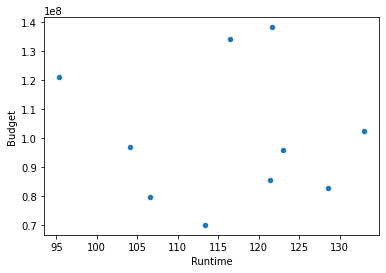

In [73]:
genregroups.plot.scatter(x = "Runtime", y = "Budget")

The above scater plot shows the relationship (or lackthereof) between average movie runtime and average movie budget. There appears to be no correlation.

In [74]:
df = genregroups[["Genre", "Runtime", "Budget in Millions"]].melt("Genre")
df

,Genre,variable,value
0,Action,Runtime,121.692722
1,Adventure,Runtime,116.437500
2,Animation,Runtime,95.387324
3,Biography,Runtime,128.604651
4,Comedy,Runtime,106.613527
5,Crime,Runtime,121.378378
6,Documentary,Runtime,85.100000
7,Drama,Runtime,123.049383
8,Fantasy,Runtime,113.333333
9,Horror,Runtime,104.148148


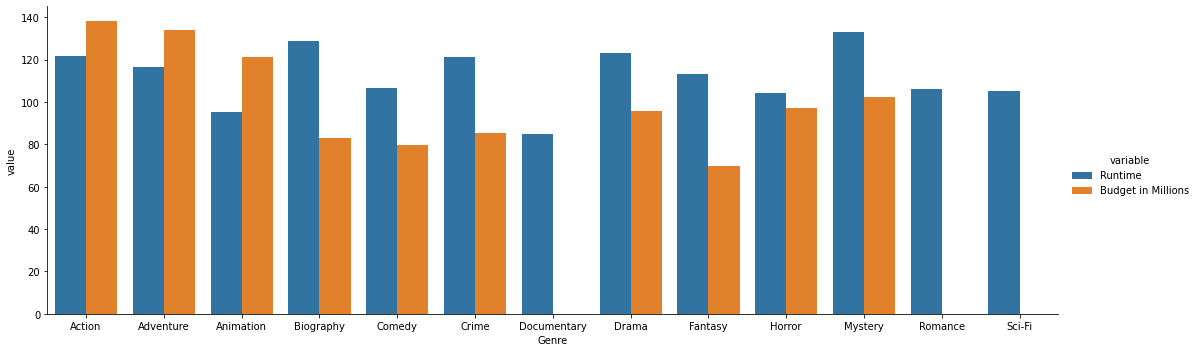

In [75]:
sns.catplot(x = "Genre", y = "value", hue = "variable", data = df, kind = "bar", aspect = 3)

The above barplot shows the average budget (in millions) of each genre of movie vs the average runtime of the movies in each genre. We know from the earlier scatterplot that there does not seem to be a correlation between average runtime and average budget. However, from this bargraph we can tell that average runtime and average budget do differ by genre.

Documentaries are boring, therefore they get the lowest average runtime!

It's worth noting that many of the genres have a low sample size, so their average runtimes may not be accurate for a wide range of movies.

Now, we'd like to compare trends over time. To do this, we need to convert the release dates into a format that can easily be compared and sorted. In the current format, we cannot use `pd.to_datetime()` so we need to manipulate the strings. Each month needs to be replaced with a numerical value.

In [76]:
months = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "May": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Oct": "10",
    "Nov": "11",
    "Dec": "12"
}
temp_col = merged["Release Date"]
for month in months:
    temp_col = temp_col.str.replace(month, months[month])
    
temp_col

0               NaN
1       04 23, 2019
2       12 17, 2009
3       02 13, 2018
4       04 25, 2018
           ...     
1486    12 25, 2008
1487    10 19, 2001
1488    01 23, 2009
1489    02 18, 2020
1490    01 14, 2000
Name: Release Date, Length: 1491, dtype: object

Now that the months are numerical, we can strip the commas and replace the spaces with a slash.

In [77]:
temp_col = temp_col.str.replace(',', '')
temp_col = temp_col.str.replace(' ', '/')
temp_col

0              NaN
1       04/23/2019
2       12/17/2009
3       02/13/2018
4       04/25/2018
           ...    
1486    12/25/2008
1487    10/19/2001
1488    01/23/2009
1489    02/18/2020
1490    01/14/2000
Name: Release Date, Length: 1491, dtype: object

Uh oh. While testing, we found an entry with a bad release date. We can replace this one with `NaN` by hand, now that we know its index.

In [78]:
merged[merged["Release Date"] == "Unknown"]

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre,Release Date,Budget,Domestic Gross,Worldwide Gross
1346,b,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,70000000.0,0.0,0.0


In [79]:
merged.at[1346, "Release Date"] = np.nan

Despite our best efforts, we could not convert the release dates into a format that could be read by `pd.to_datetime()`. We settled for a column titled "Release Year" instead, by taking the last four characters of the release date.

In [80]:
merged["Release Year"] = merged["Release Date"].str[-4:].astype(float)
merged

,Title,Runtime,User Rating,Metascore,Votes,Imdb Gross,Genre,Release Date,Budget,Domestic Gross,Worldwide Gross,Release Year
0,Star Wars: Episode VII - The Force Awakens,138.0,7.8,80.0,887830.0,936662225.0,Action,NaN,NaN,NaN,NaN,NaN
1,Avengers: Endgame,181.0,8.4,78.0,951959.0,858373000.0,Action,"Apr 23, 2019",400000000.0,858373000.0,2.797801e+09,2019.0
2,Avatar,162.0,7.8,83.0,1160469.0,760507625.0,Action,"Dec 17, 2009",237000000.0,760507625.0,2.845900e+09,2009.0
3,Black Panther,134.0,7.3,88.0,681794.0,700059566.0,Action,"Feb 13, 2018",200000000.0,700059566.0,1.336494e+09,2018.0
4,Avengers: Infinity War,149.0,8.4,68.0,933757.0,678815482.0,Action,"Apr 25, 2018",300000000.0,678815482.0,2.044541e+09,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1486,The Spirit,NaN,NaN,NaN,NaN,NaN,NaN,"Dec 25, 2008",60000000.0,19806188.0,3.900619e+07,2008.0
1487,The Last Castle,NaN,NaN,NaN,NaN,NaN,NaN,"Oct 19, 2001",60000000.0,18208078.0,2.054167e+07,2001.0
1488,Inkheart,NaN,NaN,NaN,NaN,NaN,NaN,"Jan 23, 2009",60000000.0,17303424.0,6.665594e+07,2009.0
1489,Monster Hunter,NaN,NaN,NaN,NaN,NaN,NaN,"Feb 18, 2020",60000000.0,15104790.0,4.440054e+07,2020.0


In [81]:
merged["Release Year"].value_counts()

2010.0    49
2016.0    48
2012.0    45
2013.0    45
2011.0    45
2015.0    43
2014.0    43
2009.0    42
2017.0    42
2004.0    41
2006.0    41
2002.0    41
2019.0    40
2008.0    40
2005.0    40
2003.0    40
2018.0    38
2000.0    37
2007.0    36
1998.0    33
2001.0    33
1999.0    31
1997.0    26
2021.0    18
1996.0    15
2020.0    14
1995.0    13
1994.0     5
1993.0     3
2022.0     3
1990.0     3
1991.0     3
1989.0     1
1988.0     1
1992.0     1
Name: Release Year, dtype: int64

We grouped the data by release year, and trimmed our dataset to only include the means of the "Imdb Gross" and "Budget" columns for each year.

In [82]:
releasegroups = merged.groupby("Release Year")
yearlydescribe = releasegroups[["Imdb Gross","Budget"]].mean().reset_index()
yearlydescribe

,Release Year,Imdb Gross,Budget
0,1988.0,NaN,7.000000e+07
1,1989.0,NaN,7.000000e+07
2,1990.0,NaN,6.500000e+07
3,1991.0,NaN,7.833333e+07
4,1992.0,NaN,8.000000e+07
5,1993.0,NaN,7.100000e+07
6,1994.0,5.436380e+08,7.486000e+07
7,1995.0,NaN,8.223077e+07
8,1996.0,NaN,7.633333e+07
9,1997.0,7.268861e+07,8.961538e+07


Our goal was to plot the the trend of average budgets and average IMDB gross over time. Therefore, we used the `melt` method to create a new df where a column indicated whether a value in another "Dollars" column is a IMDB gross value or a budget value.

Additionally, since the IMDB values only included years past 2000, we had to cut out the mean values for years prior to then.

In [83]:
df = yearlydescribe.melt("Release Year", value_name = "Dollars", var_name = "Type")
df = df[df["Release Year"] >= 2000]
df

,Release Year,Type,Dollars
12,2000.0,Imdb Gross,1.212999e+08
13,2001.0,Imdb Gross,1.602364e+08
14,2002.0,Imdb Gross,1.552772e+08
15,2003.0,Imdb Gross,1.395027e+08
16,2004.0,Imdb Gross,1.622822e+08
17,2005.0,Imdb Gross,1.418924e+08
18,2006.0,Imdb Gross,1.284608e+08
19,2007.0,Imdb Gross,1.717620e+08
20,2008.0,Imdb Gross,1.502576e+08
21,2009.0,Imdb Gross,1.895843e+08


<AxesSubplot:xlabel='Release Year', ylabel='Dollars'>

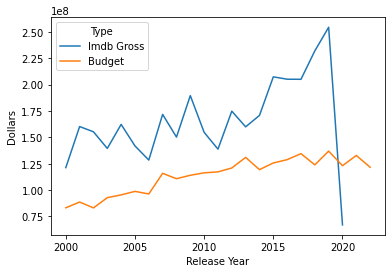

In [84]:
sns.lineplot(data=df, x = "Release Year", y = "Dollars", hue = "Type")

Disregarding the massive drop in 2020 (likely due to covid), both movie budgets and movie revenue tend to increase over time. Interestingly, when a reccesion happens (look at around the years of 2008 and 2020) movie budgets do not seem to fall nearly as much as movie revenue. Additionally, movie revenue is much more volatile year over than movie budgets. 